# Обучение с учителем

In [22]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge,Lasso,LinearRegression,LogisticRegression,LassoCV
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.preprocessing import scale,StandardScaler,PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline

### Градиентный спуск

In [3]:
#Среднеквадратичная ошибка
def mserror(y, y_pred):
    return round((sum((y - y_pred)**2)[0])/float(y.shape[0]), 3)

#Шаг градиентного спуска
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    x_k = X[train_ind, :]
    y_k = y[train_ind]
    y_pred = np.dot(x_k, w)
    l = X.shape[0]
    return w + (2*eta/l)*(y_k - y_pred)*x_k

#Алгоритм градиентного спуска
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    weight_dist = np.inf
    w = w_init
    errors = []
    iter_num = 0
    np.random.seed(seed)
    
    while weight_dist > min_weight_dist and iter_num < max_iter:
        random_ind = np.random.randint(X.shape[0])
        old_w = w
        w = stochastic_gradient_step(X, y, w, random_ind, eta=eta)
        weight_dist = np.linalg.norm(w - old_w)
        errors.append(mserror(y, np.dot(X, w)))
        iter_num += 1
       
        if iter_num % 10000 == 0 and verbose:
            print ("Iteration: ", iter_num)
       
    return w, errors

#Аналитическое решение
def normal_equation(X, y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), y)

### Прогнозирование количества прокатов

In [8]:
#Читаем данные
df = pd.read_csv('data/bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [12]:
#Подготовка данных
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

In [15]:
#Обучение модели без решуляризации
lin_reg = LinearRegression()
lin_reg.fit(X,y)
list(zip(df.columns,lin_reg.coef_))

[('season', 570.86816981128061),
 ('yr', 1021.9637175294769),
 ('mnth', -141.30232005185658),
 ('holiday', -86.763578102383946),
 ('weekday', 137.22919621308549),
 ('workingday', 56.388235274362508),
 ('weathersit', -330.23161265269113),
 ('temp', 367.47491360509792),
 ('atemp', 585.55636130486823),
 ('hum', -145.60790584172227),
 ('windspeed(mph)', 12458830091266.607),
 ('windspeed(ms)', -12458830091465.062)]

In [19]:
#Обучение модели с l2 регуляризацией
lasso_reg = Lasso()
lasso_reg.fit(X,y)
list(zip(df.columns,lasso_reg.coef_))

[('season', 560.24161603088692),
 ('yr', 1019.4634940657196),
 ('mnth', -128.7306270367875),
 ('holiday', -86.152781333711104),
 ('weekday', 137.34789390496312),
 ('workingday', 55.212370641356721),
 ('weathersit', -332.36985696234859),
 ('temp', 376.3632362096987),
 ('atemp', 576.53079350455096),
 ('hum', -144.12915500348606),
 ('windspeed(mph)', -197.1396894024858),
 ('windspeed(ms)', -2.8049811945715987e-08)]

In [20]:
#Обучение модели с l1 регуляризацией
lasso_reg = Lasso()
lasso_reg.fit(X,y)
list(zip(df.columns,lasso_reg.coef_))

[('season', 560.24161603088692),
 ('yr', 1019.4634940657196),
 ('mnth', -128.7306270367875),
 ('holiday', -86.152781333711104),
 ('weekday', 137.34789390496312),
 ('workingday', 55.212370641356721),
 ('weathersit', -332.36985696234859),
 ('temp', 376.3632362096987),
 ('atemp', 576.53079350455096),
 ('hum', -144.12915500348606),
 ('windspeed(mph)', -197.1396894024858),
 ('windspeed(ms)', -2.8049811945715987e-08)]

Best alpha:  6


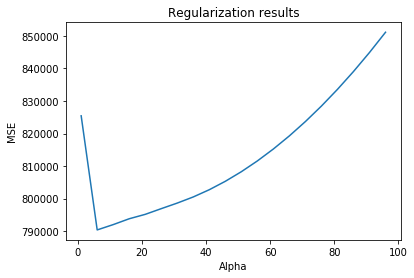

In [23]:
#Подбор параметра регуляризации
alphas = np.arange(1, 100, 5)

l_cv = LassoCV(alphas=alphas)
l_cv.fit(X,y)
l_cv_means = l_cv.mse_path_.mean(axis=1)

plt.plot(l_cv.alphas_,l_cv_means)
plt.title("Regularization results")
plt.xlabel("Alpha")
plt.ylabel("MSE")

print ('Best alpha: ',l_cv.alpha_)

### Предсказание согласования заявки

In [24]:
#Читаем данные
data = pd.read_csv('data/grants.csv')
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

In [25]:
#Обработка пропущенных значений
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

X_cat=X[categorical_cols].fillna('NA', axis=0).applymap(str)
X_real_mean=X[numeric_cols].fillna(calculate_means(X[numeric_cols]))

In [26]:
#Обработка категориальных признаков
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

In [27]:
#Разделение выборки
(X_train_real_mean, X_test_real_mean,y_train, y_test) = train_test_split(X_real_mean,y, test_size=0.3, 
                                                                         random_state=0,stratify=y)
(X_train_cat_oh,X_test_cat_oh) = train_test_split(X_cat_oh, test_size=0.3, random_state=0,stratify=y)

In [28]:
#Масштабирование
scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real_mean)
X_test_real_scaled = scaler.transform(X_test_real_mean)

In [29]:
#Обучение модели
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

X_train_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_test_scaled = np.hstack((X_test_real_scaled, X_test_cat_oh))

estimator = LogisticRegression(class_weight='balanced')
optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train_scaled, y_train)
predicted = optimizer.predict_proba(X_test_scaled)[:,1]
roc = roc_auc_score(y_test, predicted)
roc

0.87691811084740201

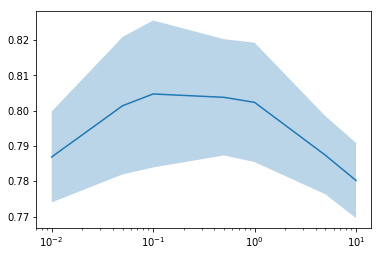

In [30]:
#Оценка точности
def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
plot_scores(optimizer)

In [31]:
#Добавление полином. признаков степени 2
transform = PolynomialFeatures(2)
X_train_real_poly = transform.fit_transform(X_train_real_mean)
X_test_real_poly = transform.transform(X_test_real_mean)
scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real_poly)
X_test_real_scaled = scaler.transform(X_test_real_poly)

X_train_poly = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_test_poly = np.hstack((X_test_real_scaled, X_test_cat_oh))

optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(X_train_poly, y_train)
Z = optimizer.predict_proba(X_test_poly)[:,1]
roc = roc_auc_score(y_test, Z)
roc

0.88566529338886157

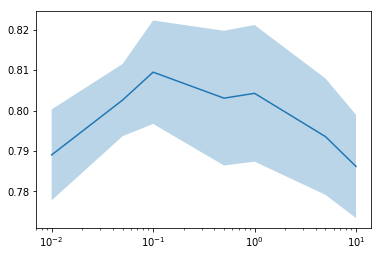

In [32]:
#Оценка точности
plot_scores(optimizer)